In [1]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [2]:
from quantum_logical.coupling_util.modular import AbstractModularCoupling


class MultiRingCorralCoupling(AbstractModularCoupling):
    def __init__(
        self,
        num_rings=2,
        snails_per_ring=8,
        switch_box_config=(2, 2),
        corral_skip_pattern=(1, 1),
    ):
        """Initialize the multi-ring corral-like coupling scheme."""
        assert (
            num_rings >= 2
        ), "Number of rings should be at least 2 for a multi-ring configuration."
        self.num_rings = num_rings
        self.snails_per_ring = snails_per_ring
        self.switch_box_config = switch_box_config
        self.corral_skip_pattern = corral_skip_pattern  # Added corral_skip_pattern
        self.qubit_to_snail_map = {}
        super().__init__(description="Multi-Ring Corral")

    def _assign_qubit_to_module(self, qubit, snail):
        if qubit not in self.qubit_to_snail_map:
            self.qubit_to_snail_map[qubit] = snail
            if snail not in self.modules:
                self.modules[snail] = []
            self.modules[snail].append(qubit)

    def _generate_ring_edges(self, ring_start, snails_per_ring):
        """Generate edges within a ring considering the corral_skip_pattern."""
        ring_edges = []
        for i in range(ring_start, ring_start + snails_per_ring):
            # Apply skip pattern for each level
            for skip in self.corral_skip_pattern:
                target_snail = (i + skip) % snails_per_ring + ring_start
                ring_edges.append((i, target_snail))
        return ring_edges

    def _generate_switch_box_edges(
        self, total_snails, num_switch_snails, connections_per_switch
    ):
        switch_box_edges = []
        base_snail_index = total_snails
        for i in range(num_switch_snails):
            for j in range(connections_per_switch):
                # Connect each switch SNAIL to a SNAIL in each ring
                ring_connection = (
                    i * connections_per_switch + j
                ) % self.snails_per_ring
                switch_box_edges.append((base_snail_index + i, ring_connection))
                switch_box_edges.append(
                    (base_snail_index + i, ring_connection + self.snails_per_ring)
                )
        return switch_box_edges

    def _construct_system(self):
        total_snails = self.num_rings * self.snails_per_ring
        self._snail_edge_list = []

        # Generate edges for each ring with skip pattern
        for r in range(self.num_rings):
            ring_start = r * self.snails_per_ring
            self._snail_edge_list += self._generate_ring_edges(
                ring_start, self.snails_per_ring
            )

        # Generate switch box edges without applying the skip pattern
        self._snail_edge_list += self._generate_switch_box_edges(
            total_snails, *self.switch_box_config
        )

        # Update total snails to include switch boxes
        total_snails += self.switch_box_config[0]

        self.c_map = self._snail_to_connectivity(self._snail_edge_list)
        self.module_depths = {snail: snail for snail in range(total_snails)}

    def _snail_to_connectivity(self, snail_edge_list):
        edge_list = []
        for qubit, snail_edge in enumerate(snail_edge_list):
            self._assign_qubit_to_module(qubit, snail_edge[0])
            for temp_qubit, temp_snail_edge in enumerate(snail_edge_list):
                if qubit != temp_qubit and (
                    snail_edge[0] in temp_snail_edge or snail_edge[1] in temp_snail_edge
                ):
                    edge_list.append((qubit, temp_qubit))
        return edge_list

In [3]:
def plot_graph_with_module_colors(
    G, pos, node_colors, label_text, edge_color="gray", node_size=500
):
    import matplotlib.pyplot as plt
    import networkx as nx

    plt.figure(figsize=(10, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        edge_color=edge_color,
        node_size=node_size,
    )
    plt.title(label_text)
    plt.axis("off")
    plt.show()


def plot_qubit_graph(pb, label_text):
    import networkx as nx
    import matplotlib.pyplot as plt

    # Define colors for different modules
    level_colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
        "tab:gray",
    ]

    G_qubit = nx.Graph()
    G_qubit.add_edges_from(
        pb.get_edges()
    )  # Assuming c_map represents qubit-qubit connectivity

    modules, module_depths = pb.modules, pb.module_depths

    # Node colors based on modules
    node_colors = [
        level_colors[module_depths[pb.qubit_to_snail_map[q]] % len(level_colors)]
        for q in G_qubit.nodes()
    ]

    # Generate layout
    pos_qubit = nx.kamada_kawai_layout(G_qubit)

    plot_graph_with_module_colors(
        G_qubit, pos_qubit, node_colors, f"{label_text} - Qubit Graph"
    )


# For SNAIL graph, assuming each SNAIL is its own "module" or using a specific criterion for differentiation
def plot_snail_graph(pb, label_text):
    import networkx as nx

    G_snail = nx.Graph()
    G_snail.add_edges_from(
        pb._snail_edge_list
    )  # Assuming _snail_edge_list is available

    # Assuming a straightforward color coding for SNAILs or using a specific attribute for coloring
    # For demonstration, using a single color here
    node_colors = (
        "lightgreen"  # This could be adapted to use module-based logic if applicable
    )

    # Generate layout
    pos_snail = nx.kamada_kawai_layout(G_snail)

    plot_graph_with_module_colors(
        G_snail,
        pos_snail,
        node_colors,
        f"{label_text} - SNAIL Graph",
        edge_color="black",
        node_size=700,
    )

Modules: {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4: [8, 9], 5: [10, 11], 6: [12, 13], 7: [14, 15], 8: [16, 17], 9: [18, 19], 10: [20, 21], 11: [22, 23], 12: [24, 25], 13: [26, 27], 14: [28, 29], 15: [30, 31], 16: [32, 33, 34, 35], 17: [36, 37, 38, 39]}
Coupling Map: [(16, 29), (18, 35), (8, 9), (17, 21), (21, 37), (0, 14), (11, 14), (17, 30), (28, 30), (7, 10), (24, 26), (19, 39), (18, 19), (16, 31), (3, 6), (18, 37), (20, 22), (3, 15), (14, 15), (8, 11), (9, 10), (2, 4), (23, 27), (18, 21), (2, 34), (16, 33), (38, 39), (9, 12), (22, 39), (16, 17), (25, 29), (2, 36), (16, 35), (12, 13), (22, 23), (21, 25), (0, 2), (31, 35), (4, 36), (13, 14), (27, 31), (16, 19), (33, 35), (0, 32), (12, 15), (5, 9), (22, 25), (23, 24), (6, 38), (20, 37), (1, 5), (4, 38), (19, 20), (1, 14), (24, 25), (1, 32), (0, 34), (16, 30), (20, 21), (15, 34), (29, 33), (23, 26), (14, 32), (19, 22), (36, 38), (2, 15), (19, 31), (7, 11), (30, 31), (25, 26), (32, 34), (3, 7), (4, 6), (20, 23), (21, 22), (26, 27), 

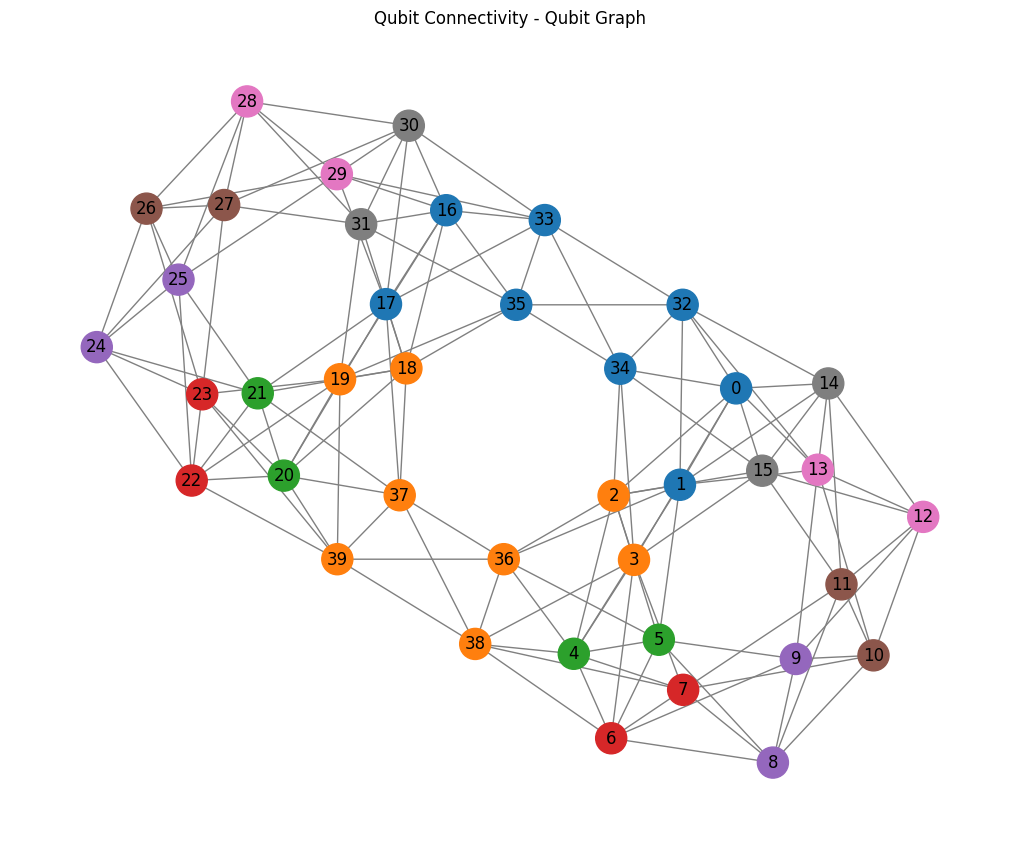

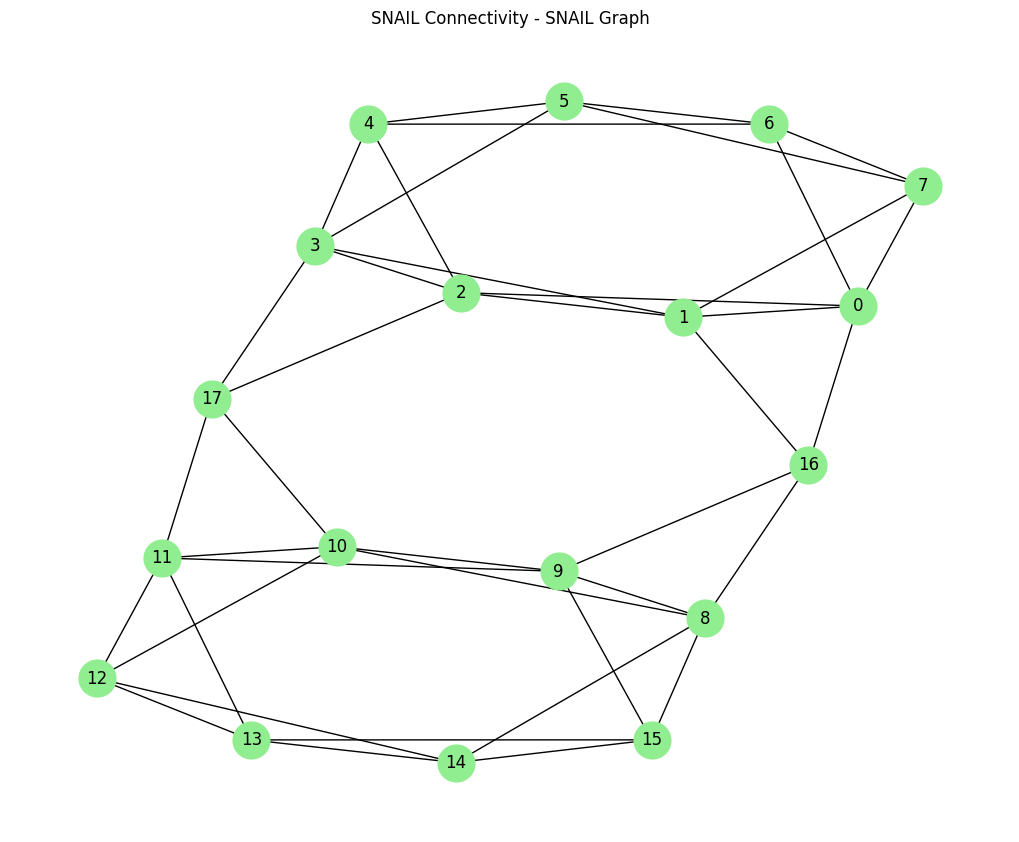

In [4]:
# Assuming MultiRingCorralCoupling is correctly implemented and instantiated
fake_modular = MultiRingCorralCoupling(
    num_rings=2,
    snails_per_ring=8,
    switch_box_config=(2, 2),
    corral_skip_pattern=(1, 2),
)

print("Modules:", fake_modular.modules)
print("Coupling Map:", fake_modular.c_map)
# Assuming 'long_edges' is an optional attribute you might have added
# print("Long Edges:", getattr(fake_modular, 'long_edges', 'Not defined'))

# Visualize the Qubit Connectivity
plot_qubit_graph(fake_modular, "Qubit Connectivity")

# Visualize the SNAIL Connectivity
plot_snail_graph(fake_modular, "SNAIL Connectivity")

In [5]:
from transpile_benchy.interfaces.qiskit_interface import (
    # QiskitCircuitInterface,
    QuantumCircuitFactory,
)
from qiskit.circuit.library import TwoLocal

num_qubits = [32]


def full(n):
    return TwoLocal(n, "ry", "cz", entanglement="full", reps=3)

In [6]:
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary.from_submodules(
    [
        QuantumCircuitFactory(full, num_qubits),
        # QuantumCircuitFactory(linear_two_local, num_qubits),
    ]
)

In [7]:
from transpile_benchy.passmanagers.qiskit_baseline import QiskitBaseline
from quantum_logical.coupling_util import CorralCoupling

# from qiskit.transpiler import CouplingMap
# from quantum_logical.coupling_util import CorralCoupling, TreeCoupling

corral16 = CorralCoupling(num_snails=16, corral_skip_pattern=(0, 0))
corral16_skip = CorralCoupling(num_snails=16, corral_skip_pattern=(0, 1))
mutlicorral = MultiRingCorralCoupling(2, 8, corral_skip_pattern=(1, 1))
multicorral_skip = MultiRingCorralCoupling(2, 8, corral_skip_pattern=(1, 2))


baseline_corral = QiskitBaseline(optimization_level=3, coupling_map=corral16)
baseline_corral_skip = QiskitBaseline(optimization_level=3, coupling_map=corral16_skip)
baseline_multicorral = QiskitBaseline(optimization_level=3, coupling_map=mutlicorral)
baseline_multicorral_skip = QiskitBaseline(
    optimization_level=3, coupling_map=multicorral_skip
)

# FIXME, we don't have a way of distinguishing between these transpilers w/o a name
baseline_corral.name = "corral"
baseline_corral_skip.name = "corral_skip"
baseline_multicorral.name = "multicorral"
baseline_multicorral_skip.name = "multicorral_skip"

transpilers = [
    baseline_corral,
    baseline_corral_skip,
    baseline_multicorral,
    baseline_multicorral_skip,
]

In [8]:
from transpile_benchy.metrics.abc_metrics import MetricInterface
from qiskit.transpiler.basepasses import AnalysisPass
from monodromy.coverage import convert_gate_to_monodromy_coordinate
import numpy as np
from transpile_benchy.metrics.abc_metrics import DoNothing


class CombinedMetricsPass(AnalysisPass):
    """Combined pass for calculating CCR, Mean Qubit Hotspotness, and Temporal Burstiness."""

    def __init__(self):
        super().__init__()

    def run(self, dag):
        # Initialize counters and storage
        num_swap = 0
        num_computation = 0
        swap_counts = {q: 0 for q in dag.qubits}
        layer_swap_counts = []

        for layer_i, layer in enumerate(dag.layers()):
            layer_swap_counts.append(0)
            for gate_node in layer["graph"].two_qubit_ops():
                t_c = convert_gate_to_monodromy_coordinate(gate_node.op)
                if np.allclose(t_c, [0.25, 0.25, 0.25, -0.75]):
                    num_swap += 1
                    layer_swap_counts[layer_i] += 1
                    for q in gate_node.qargs:
                        swap_counts[q] += 1
                else:
                    num_computation += 1

        # Calculate metrics
        ccr = num_swap / num_computation if num_computation != 0 else 0
        mean_swap = np.mean(list(swap_counts.values()))
        variance_swap = np.var(list(swap_counts.values()))
        mean_qubit_hotspotness = variance_swap / mean_swap if mean_swap != 0 else 0
        layer_mean_swap = np.mean(layer_swap_counts)
        layer_variance_swap = np.var(layer_swap_counts)
        temporal_burstiness = (
            layer_variance_swap / layer_mean_swap if layer_mean_swap != 0 else 0
        )

        # Store metrics in the property set
        self.property_set["ccr"] = ccr
        self.property_set["mean_qubit_hotspotness"] = mean_qubit_hotspotness
        self.property_set["temporal_burstiness"] = temporal_burstiness


class CCR(MetricInterface):
    """CCR metric utilizing the CombinedMetricsPass for computation."""

    def __init__(self):
        super().__init__(name="ccr", pretty_name="CCR")

    def _construct_pass(self):
        return CombinedMetricsPass()


class MeanQubitHotspotness(MetricInterface):
    """Mean Qubit Hotspotness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(
            name="mean_qubit_hotspotness", pretty_name="Mean Qubit Hotspotness"
        )

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()


class TemporalBurstiness(MetricInterface):
    """Temporal Burstiness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(name="temporal_burstiness", pretty_name="Temporal Burstiness")

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()

In [9]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks

depth_metric = DepthMetric(consolidate=False)
total_metric = TotalMetric(consolidate=False)

ccr_metric = CCR()
mean_qubit_hotspotness_metric = MeanQubitHotspotness()
temporal_burstiness_metric = TemporalBurstiness()

metrics = [
    depth_metric,
    total_metric,
    ccr_metric,
    mean_qubit_hotspotness_metric,
    temporal_burstiness_metric,
]

requires = [Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]

for transpiler in transpilers:
    transpiler._append_metric_dependencies(requires)

In [10]:
benchmark = Benchmark(
    transpilers=transpilers,
    metrics=metrics,
    circuit_library=lib,
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


Circuits from library:   0%|          | 0/1 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit full_n32


Loading full_n32 from QuantumCircuitFactory


Circuits from library: 100%|██████████| 1/1 [00:52<00:00, 52.72s/it]


In [11]:
print(benchmark)


Transpiler: corral

  Metric: ccr
  Circuit: full_n32                                 Mean result: 0.356                          Trials: [0.35685483870967744, 0.35618279569892475, 0.3541666666666667]

  Metric: mean_qubit_hotspotness
  Circuit: full_n32                                 Mean result: 3.582                          Trials: [3.8012005649717513, 3.4070754716981133, 3.53688330170778]

  Metric: monodromy_depth
  Circuit: full_n32                                 Mean result: 685.305                        Trials: [734.0, 683.0, 642.0]

  Metric: monodromy_total
  Circuit: full_n32                                 Mean result: 3225.328                       Trials: [3233.0, 3224.0, 3219.0]

  Metric: temporal_burstiness
  Circuit: full_n32                                 Mean result: 0.772                          Trials: [0.7600044311509915, 0.7852903462172558, 0.770187111185838]

  Metric: total_runtime
  Circuit: full_n32                                 Mean result: 4.324  

In [13]:
# benchmark.summary_statistics(baseline_sq, baseline_hh)

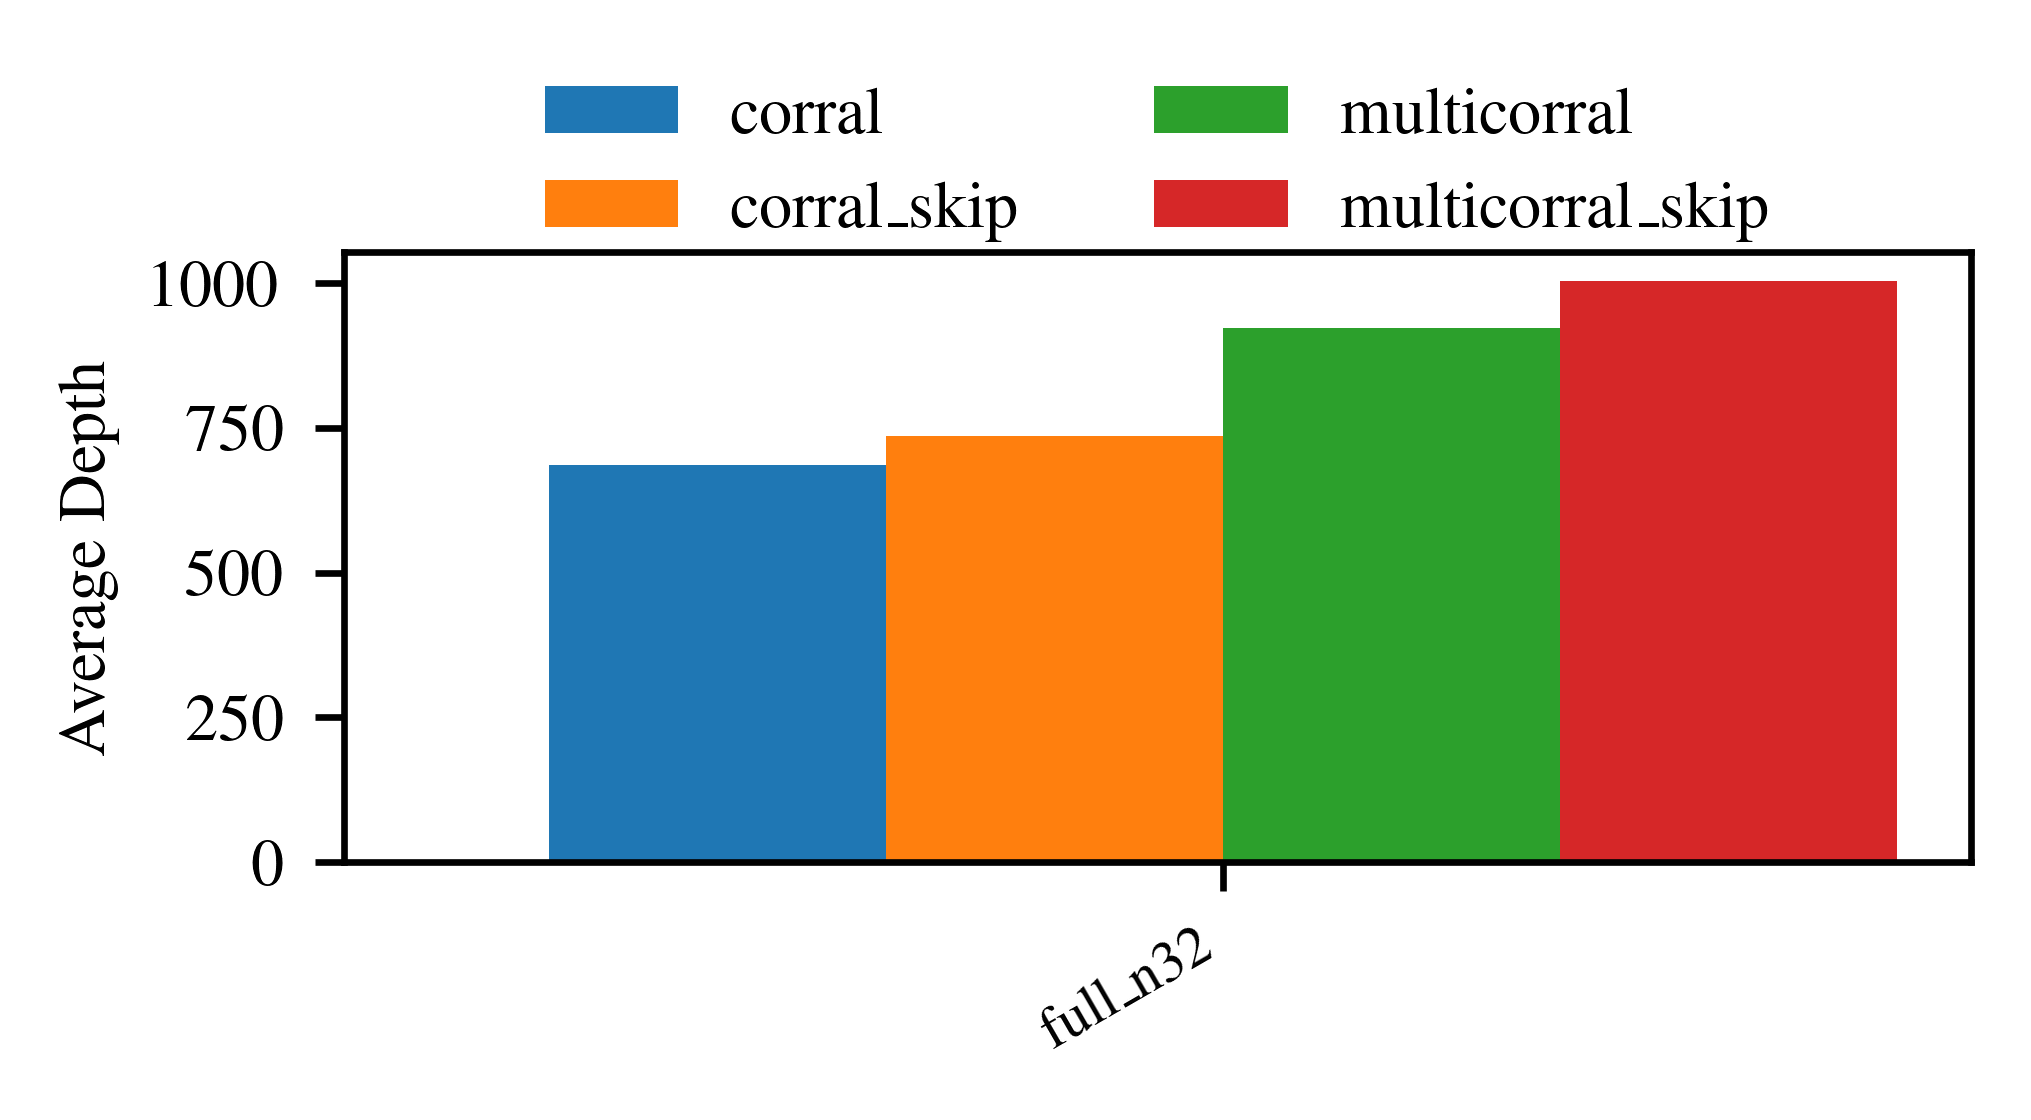

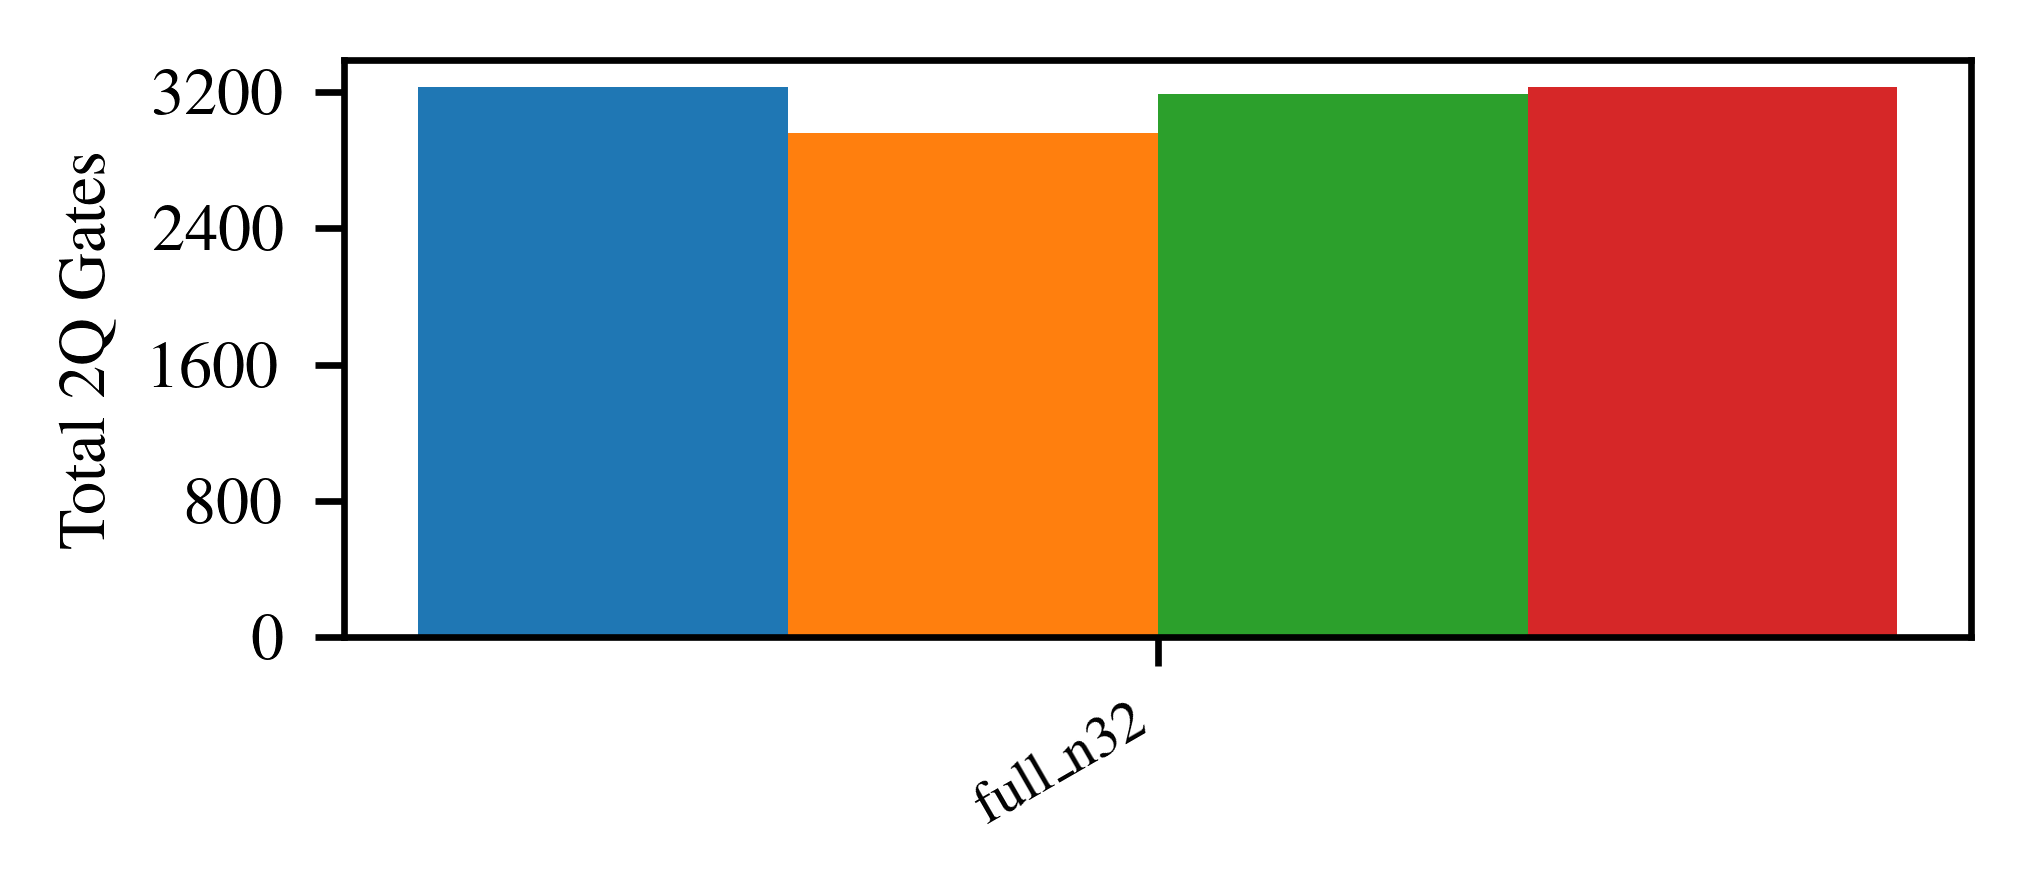

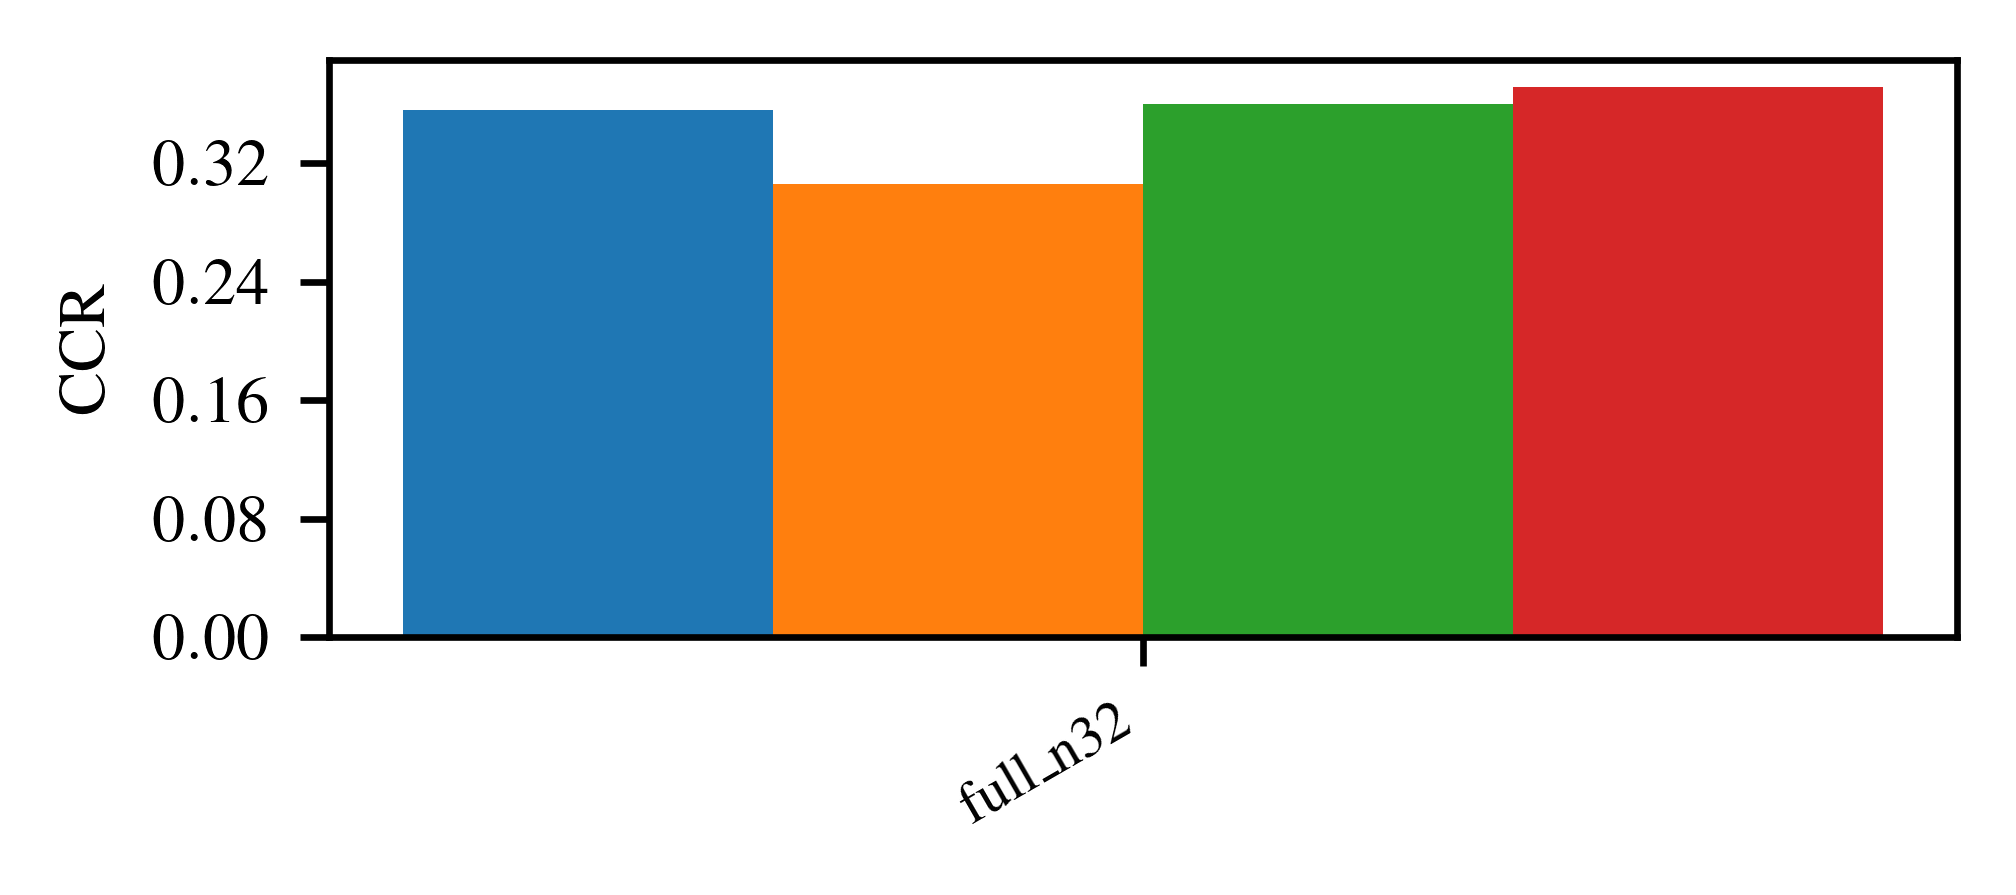

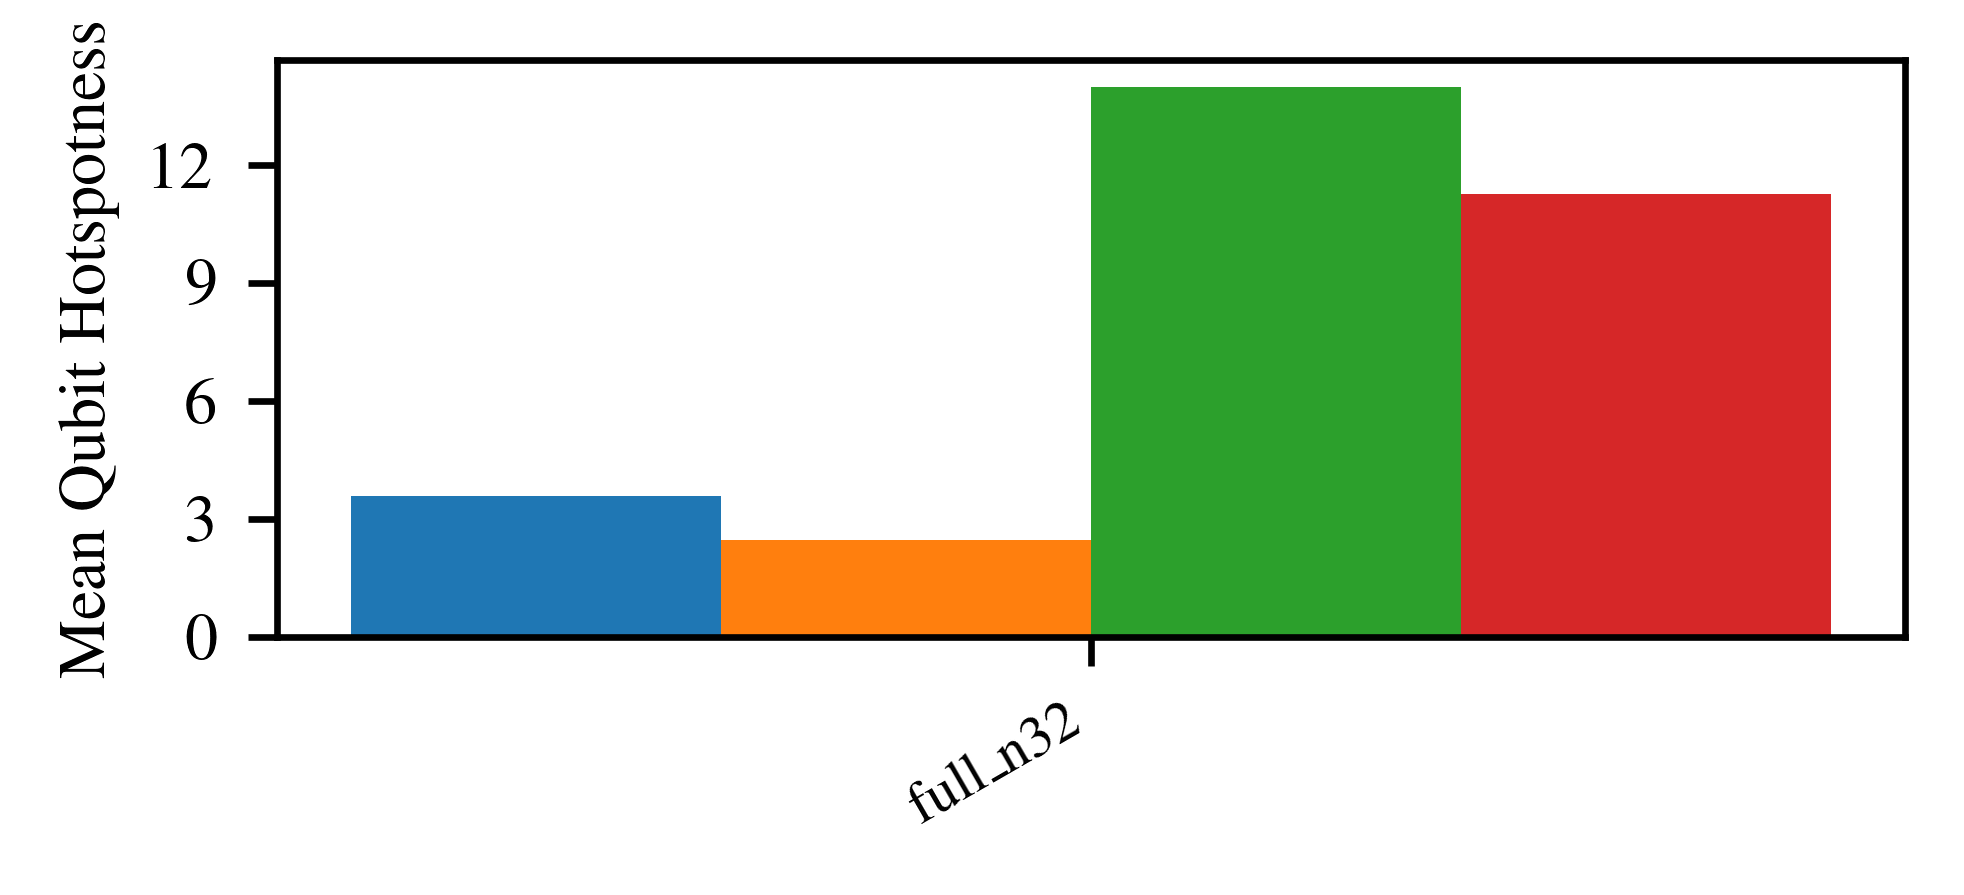

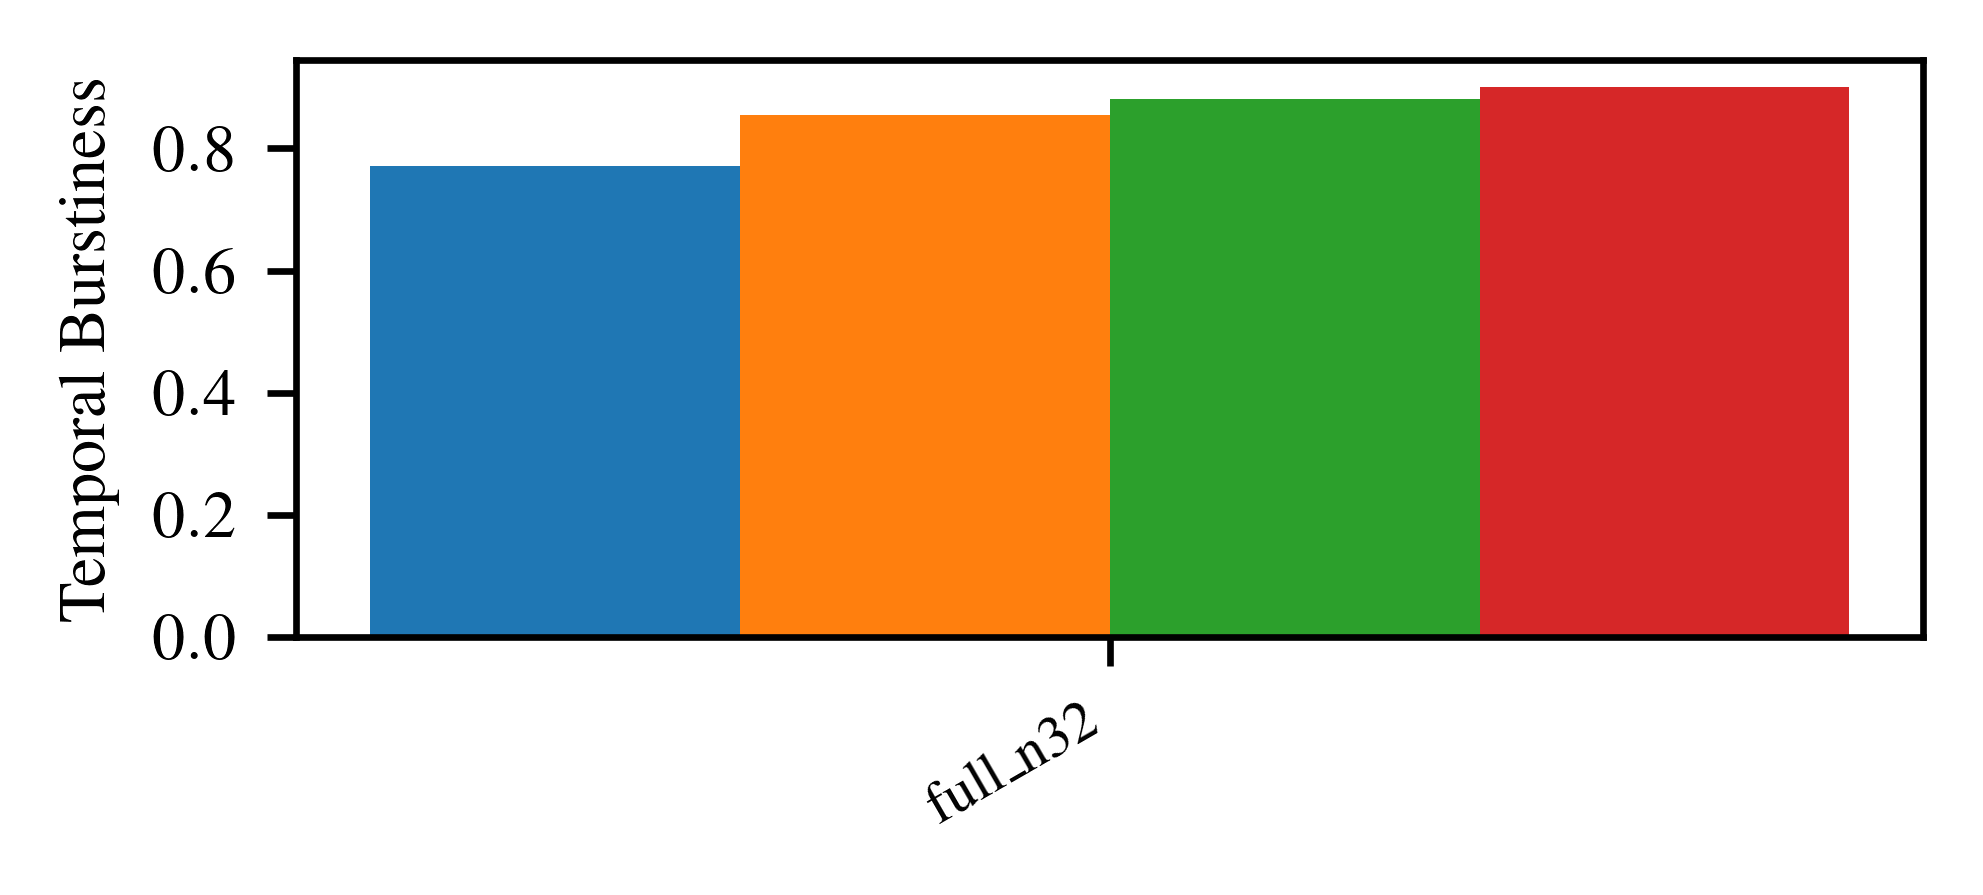

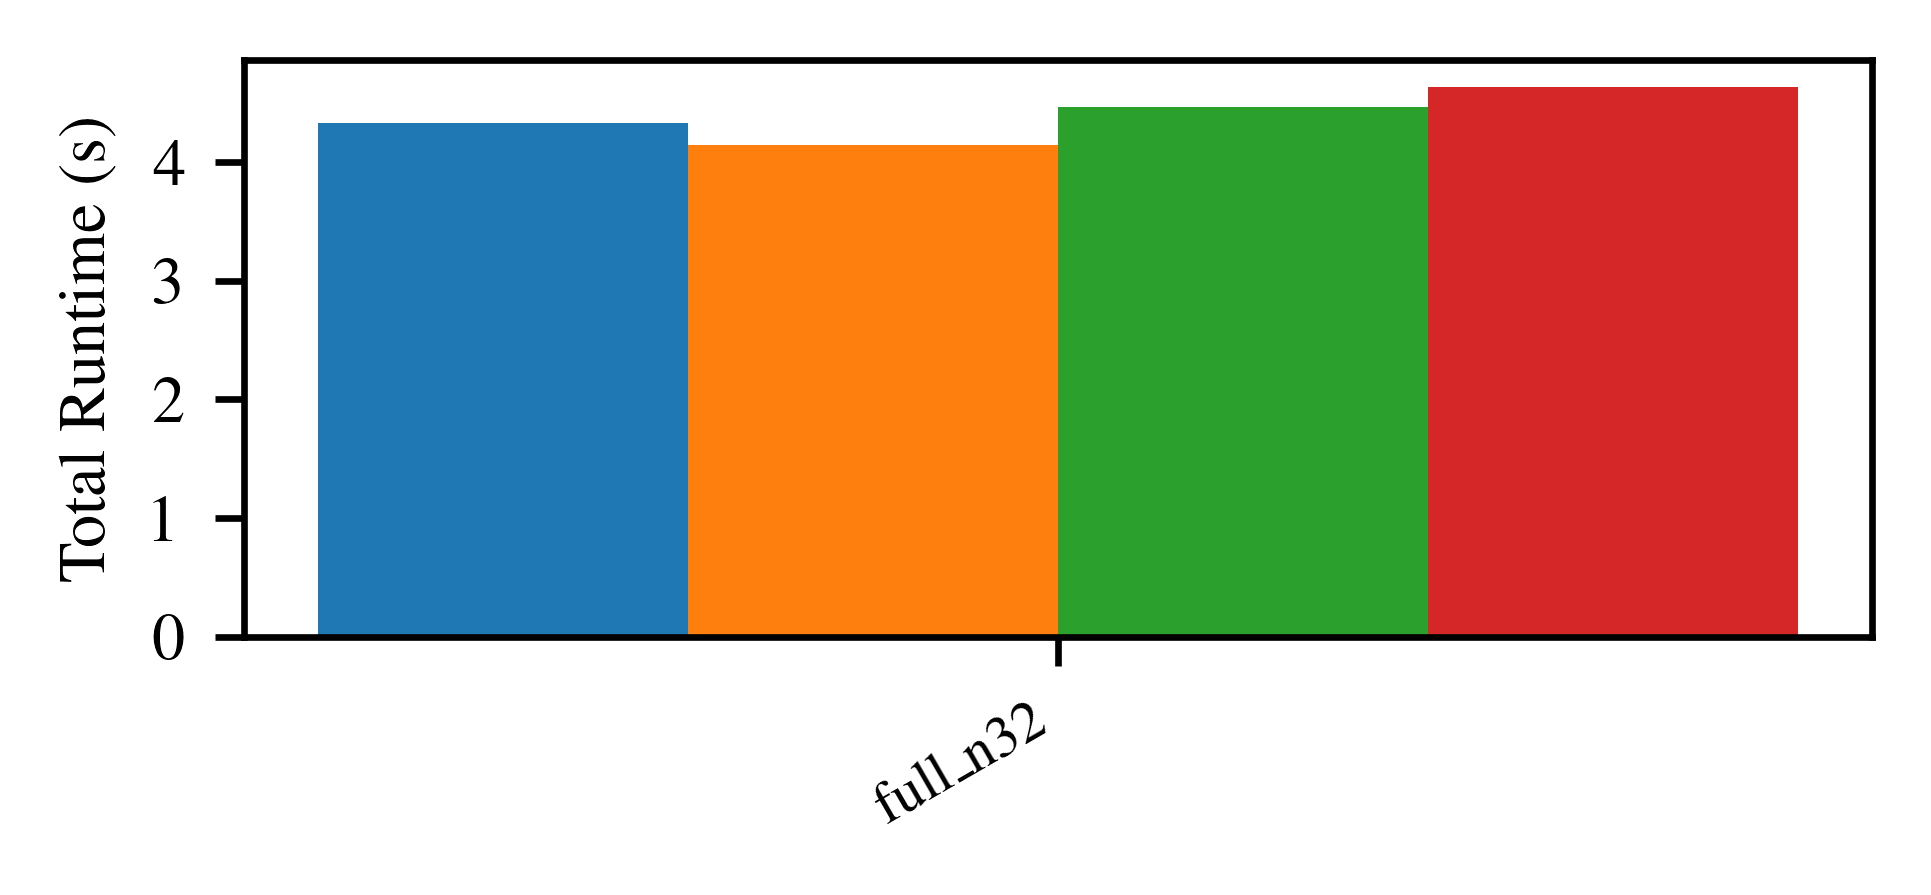

In [14]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark, save=0, legend_show=1)